Implementacja modelu w PyTorch

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultiInputModel(nn.Module):
    def __init__(self, num_classes,image_size_x = 224,image_size_y = 224, filter_num_base = 4):
        super(MultiInputModel, self).__init__()
        
        # Sieć dla obrazów RGB (widok T i B) 
        self.rgb_model = models.efficientnet_b0(pretrained=True)
        self.rgb_model.classifier = nn.Identity()  # Usuń ostatnią warstwę

        # Sieć dla obrazu binarnego (widok S)
        
        self.binary_model = nn.Sequential(
            nn.Conv2d(1, filter_num_base*2, kernel_size=3, stride=1, padding=1),  # 1-kanałowe wejście
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(filter_num_base*2, filter_num_base*4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(filter_num_base*4 * (image_size_x // 4) * (image_size_y // 4), filter_num_base*32),  # Dopasowanie rozmiarów
            nn.ReLU()
        )

        # Warstwa łącząca
        self.fc = nn.Sequential(
            nn.Linear(1280 + 1280 + 256, 512),  # 1280 (T) + 1280 (B) + 256 (S)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, t_image, b_image, s_image):
        # Ekstrakcja cech dla widoków RGB
        t_features = self.rgb_model(t_image)  # Widok T
        b_features = self.rgb_model(b_image)  # Widok B

        # Ekstrakcja cech dla obrazu binarnego
        s_features = self.binary_model(s_image)

        # Połączenie cech
        combined_features = torch.cat([t_features, b_features, s_features], dim=1)

        # Klasyfikacja
        output = self.fc(combined_features)
        return output


Krok 1: Przygotowanie danych. Przygotuj dane dla modelu multi-input w formie DataLoader, gdzie każda próbka zawiera trzy obrazy (*_T.png, *_B.png, *_S.png) i ich klasę. <br>
Krok 2: Transformacje dla obrazów RGB i binarnych:

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd

class MultiInputDataset(Dataset):
    def __init__(self, csv_file, transform_rgb=None, transform_binary=None):
        self.data = pd.read_csv(csv_file)

        # Tworzenie mapowania nazw klas na liczby całkowite
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.data['class'].unique())}

        self.transform_rgb = transform_rgb
        self.transform_binary = transform_binary

    def __len__(self):
        return len(self.data) // 3  # Każde ziarno ma 3 obrazy

    def __getitem__(self, idx):
        # Pobierz trzy obrazy
        base_idx = idx * 3
        t_path = self.data.iloc[base_idx]['path']
        b_path = self.data.iloc[base_idx + 1]['path']
        s_path = self.data.iloc[base_idx + 2]['path']

        t_image = Image.open(t_path).convert("RGB")
        b_image = Image.open(b_path).convert("RGB")
        s_image = Image.open(s_path).convert("L")  # Obraz binarny

        # Transformacje
        if self.transform_rgb:
            t_image = self.transform_rgb(t_image)
            b_image = self.transform_rgb(b_image)
        if self.transform_binary:
            s_image = self.transform_binary(s_image)

        # Pobierz nazwę klasy i przekształć na indeks numeryczny
        class_name = self.data.iloc[base_idx]['class']
        label = self.class_to_idx[class_name]  # Mapowanie nazwy klasy na numer
        label = torch.tensor(label, dtype=torch.long)  # Konwersja na tensor PyTorch

        return t_image, b_image, s_image, label

#Krok 2: Transformacje dla obrazów RGB i binarnych:
from torchvision import transforms

# Transformacje dla obrazów RGB
transform_rgb = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformacje dla obrazów binarnych
transform_binary = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

Krok 3: Trenowanie modelu

In [4]:
from torch.utils.data import DataLoader
import torch.optim as optim
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Załaduj dane
train_dataset = MultiInputDataset("CSV/dataset/train.csv", transform_rgb=transform_rgb, transform_binary=transform_binary)
val_dataset = MultiInputDataset("CSV/dataset/val.csv", transform_rgb=transform_rgb, transform_binary=transform_binary)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Inicjalizacja modelu
model = MultiInputModel(num_classes=11)  # Liczba klas
model = model.to("cuda")  # Jeśli używasz GPU

# Optymalizator i funkcja straty
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Pętla treningowa
for epoch in range(10):
    model.train()
    total_loss = 0
    for t_image, b_image, s_image, labels in train_loader:
        t_image, b_image, s_image, labels = (
            t_image.to("cuda"),
            b_image.to("cuda"),
            s_image.to("cuda"),
            labels.to("cuda")
        )

        # Oblicz predykcje i stratę
        outputs = model(t_image, b_image, s_image)

        #print(f"Outputs shape: {outputs.shape}")  # Dodaj tę linię
        #print(f"Labels shape: {labels.shape}")    # Dodaj tę linię
        #print(f"Labels min: {labels.min()}, Labels max: {labels.max()}")  # Dodaj tę linię
        #print(f"Labels dtype: {labels.dtype}")  # Dodaj tę linię

        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")


/home/mk/miniconda3/envs/dnn_gpu/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mk/miniconda3/envs/dnn_gpu/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.4125
Epoch 2, Loss: 0.1834
Epoch 3, Loss: 0.1483
Epoch 4, Loss: 0.1231
Epoch 5, Loss: 0.1012
Epoch 6, Loss: 0.0898
Epoch 7, Loss: 0.0808
Epoch 8, Loss: 0.0705
Epoch 9, Loss: 0.0650
Epoch 10, Loss: 0.0578


Testy modelu:
Wynik
Macierz pomyłek:

Wizualizacja macierzy pomyłek pokazuje liczbę poprawnych klasyfikacji (wartości na przekątnej) i błędnych klasyfikacji (wartości poza przekątną).
Dokładność (Accuracy):

Ogólna dokładność modelu, tj. stosunek poprawnie sklasyfikowanych przykładów do wszystkich przykładów.
Raport klasyfikacji:

Wyświetlenie takich metryk jak:
Precision: Dokładność przewidywań dla danej klasy.
Recall: Odsetek poprawnie sklasyfikowanych przykładów w danej klasie.
F1-score: Średnia harmoniczna precyzji i czułości.

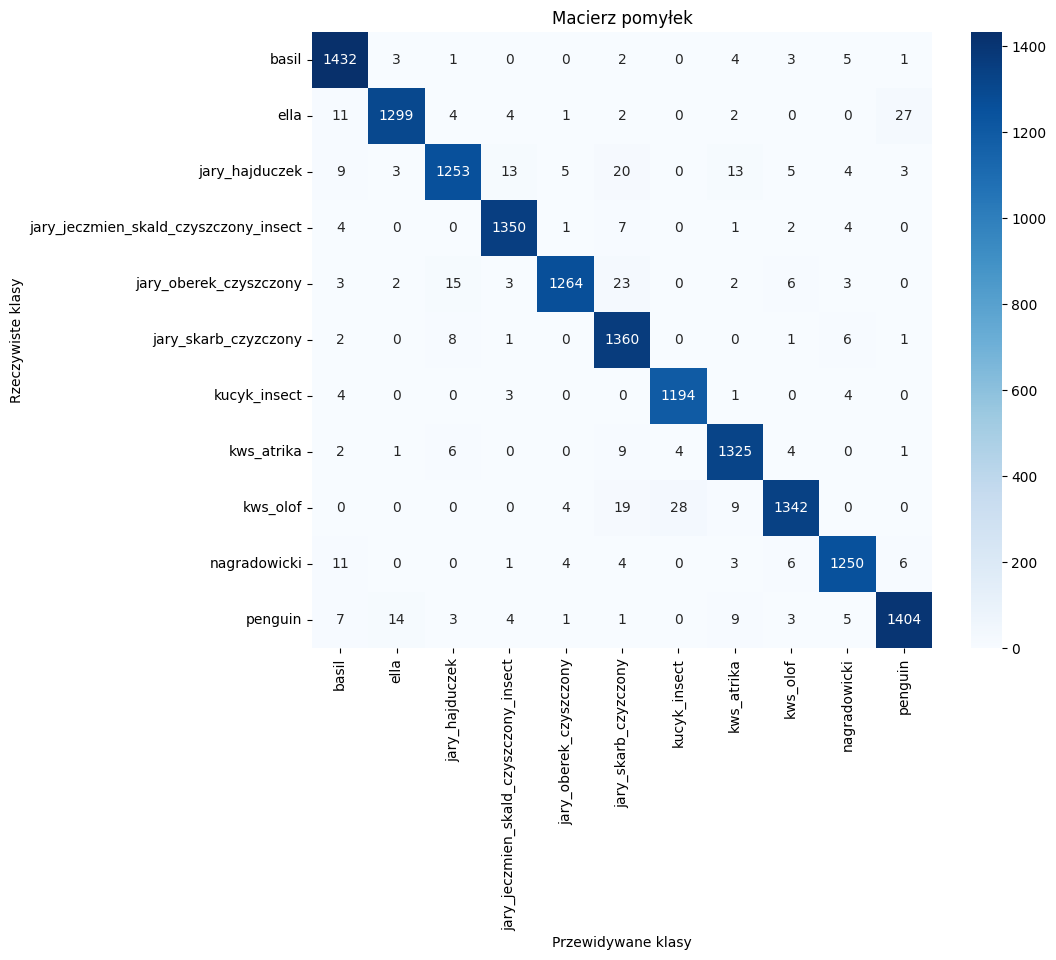

Dokładność: 0.9717335839935545

Raport klasyfikacji:
                                       precision    recall  f1-score   support

                                basil       0.96      0.99      0.98      1451
                                 ella       0.98      0.96      0.97      1350
                       jary_hajduczek       0.97      0.94      0.96      1328
jary_jeczmien_skald_czyszczony_insect       0.98      0.99      0.98      1369
               jary_oberek_czyszczony       0.99      0.96      0.97      1321
                 jary_skarb_czyzczony       0.94      0.99      0.96      1379
                         kucyk_insect       0.97      0.99      0.98      1206
                           kws_atrika       0.97      0.98      0.97      1352
                             kws_olof       0.98      0.96      0.97      1402
                         nagradowicki       0.98      0.97      0.97      1285
                              penguin       0.97      0.97      0.97      145

In [6]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def test_model(model, test_loader, class_to_idx, device="cuda"):
    """
    Testuje model na zbiorze testowym i wyznacza macierz pomyłek.

    Args:
        model (nn.Module): Wytrenowany model.
        test_loader (DataLoader): DataLoader dla zbioru testowego.
        class_to_idx (dict): Mapowanie nazw klas na liczby całkowite.
        device (str): Urządzenie ("cuda" lub "cpu").

    Returns:
        confusion_matrix: Macierz pomyłek.
        y_true: Rzeczywiste etykiety.
        y_pred: Przewidywane etykiety.
    """
    model.eval()  # Ustawienie modelu w tryb ewaluacji
    y_true = []
    y_pred = []

    with torch.no_grad():
        for t_image, b_image, s_image, labels in test_loader:
            t_image, b_image, s_image, labels = (
                t_image.to(device),
                b_image.to(device),
                s_image.to(device),
                labels.to(device)
            )

            # Oblicz predykcje
            outputs = model(t_image, b_image, s_image)
            _, predicted = torch.max(outputs, 1)

            # Zbierz rzeczywiste i przewidywane etykiety
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Wyznaczenie macierzy pomyłek
    cm = confusion_matrix(y_true, y_pred)

    return cm, y_true, y_pred


# Załaduj dane
test_dataset = MultiInputDataset("CSV/dataset/test.csv", transform_rgb=transform_rgb, transform_binary=transform_binary)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Wywołanie funkcji testującej
cm, y_true, y_pred = test_model(model, test_loader, test_dataset.class_to_idx)

# Wyświetlenie macierzy pomyłek
class_names = list(test_dataset.class_to_idx.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Przewidywane klasy")
plt.ylabel("Rzeczywiste klasy")
plt.title("Macierz pomyłek")
plt.show()

# Inne metryki
print("Dokładność:", accuracy_score(y_true, y_pred))
print("\nRaport klasyfikacji:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [7]:
import numpy as np

# Wyświetl pary klas z największą liczbą pomyłek (poza przekątną)
off_diagonal = cm - np.diag(np.diag(cm))  # Macierz bez przekątnej
max_misclassified = np.unravel_index(np.argmax(off_diagonal), off_diagonal.shape)

print(f"Najczęściej mylone klasy: {class_names[max_misclassified[0]]} → {class_names[max_misclassified[1]]}")
print(f"Liczba pomyłek: {off_diagonal[max_misclassified]}")

Najczęściej mylone klasy: kws_olof → kucyk_insect
Liczba pomyłek: 28


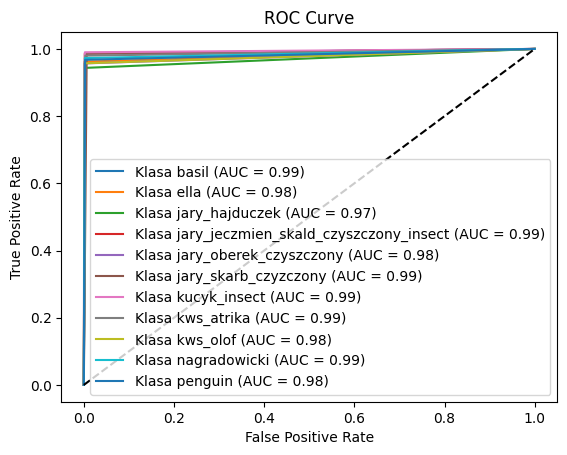

In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarizacja etykiet dla OvR
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
y_pred_bin = label_binarize(y_pred, classes=range(len(class_names)))

# Obliczanie ROC i AUC dla każdej klasy
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Klasa {class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Linia bazowa
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [9]:
# Znajdź indeksy przykładów błędnie sklasyfikowanych
error_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]

# Wyświetl kilka przykładów błędów
for idx in error_indices[:5]:  # Pierwsze 5 błędów
    print(f"Rzeczywista klasa: {class_names[y_true[idx]]}, Przewidywana klasa: {class_names[y_pred[idx]]}")
    # Opcjonalnie: Wyświetl obrazy (zależy od implementacji Dataset)


Rzeczywista klasa: penguin, Przewidywana klasa: jary_jeczmien_skald_czyszczony_insect
Rzeczywista klasa: jary_oberek_czyszczony, Przewidywana klasa: jary_hajduczek
Rzeczywista klasa: kucyk_insect, Przewidywana klasa: kws_atrika
Rzeczywista klasa: kws_olof, Przewidywana klasa: jary_skarb_czyzczony
Rzeczywista klasa: jary_oberek_czyszczony, Przewidywana klasa: jary_skarb_czyzczony


In [11]:
from torchviz import make_dot
import torch

# Inicjalizacja modelu
num_classes = 11  # Liczba klas w Twoim zadaniu
model = MultiInputModel(num_classes=num_classes)

# Przygotowanie danych wejściowych
t_image = torch.randn(1, 3, 224, 224)  # Przykładowy obraz RGB widok T (batch_size=1)
b_image = torch.randn(1, 3, 224, 224)  # Przykładowy obraz RGB widok B
s_image = torch.randn(1, 1, 224, 224)  # Przykładowy obraz binarny widok S

# Przepływ danych przez model
outputs = model(t_image, b_image, s_image)

# Tworzenie wizualizacji modelu
dot = make_dot(outputs, params=dict(model.named_parameters()))
dot.render("model_architecture", format="png")  # Zapisz jako plik PNG


/home/mk/miniconda3/envs/dnn_gpu/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mk/miniconda3/envs/dnn_gpu/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


'model_architecture.png'

In [12]:
from graphviz import Digraph

# Inicjalizacja diagramu
dot = Digraph(comment="Uproszczona Architektura Multi-Input Model")

# Wejścia
dot.node("Input_T", "Widok z góry (_T)", shape="box", style="rounded,filled", fillcolor="lightblue")
dot.node("Input_B", "Widok z dołu (_B)", shape="box", style="rounded,filled", fillcolor="lightblue")
dot.node("Input_S", "Widok z boku (_S)", shape="box", style="rounded,filled", fillcolor="lightgreen")

# Przetwarzanie
dot.node("EfficientNet_T", "EfficientNet", shape="ellipse", style="filled", fillcolor="lightyellow")
dot.node("EfficientNet_B", "EfficientNet", shape="ellipse", style="filled", fillcolor="lightyellow")
dot.node("BinaryCNN", "Custom CNN (Binary)", shape="ellipse", style="filled", fillcolor="orange")

# Połączenie i klasyfikacja
dot.node("Concat", "Połączenie cech", shape="box", style="rounded,filled", fillcolor="lightgrey")
dot.node("FC", "Fully Connected", shape="ellipse", style="filled", fillcolor="pink")
dot.node("Output", "Klasyfikacja", shape="box", style="rounded,filled", fillcolor="lightcoral")

# Połączenia między komponentami
dot.edges([("Input_T", "EfficientNet_T"), ("Input_B", "EfficientNet_B"), ("Input_S", "BinaryCNN")])
dot.edges([("EfficientNet_T", "Concat"), ("EfficientNet_B", "Concat"), ("BinaryCNN", "Concat")])
dot.edge("Concat", "FC")
dot.edge("FC", "Output")

# Render diagramu
dot.render("simplified_architecture", format="png", cleanup=True)


'simplified_architecture.png'

In [13]:
from graphviz import Digraph

# Inicjalizacja diagramu
dot = Digraph(comment="Szczegółowa Architektura Multi-Input Model")

# Wejścia
dot.node("Input_T", "Widok z góry (_T)\n(3 x 224 x 224)", shape="box", style="rounded,filled", fillcolor="lightblue")
dot.node("Input_B", "Widok z dołu (_B)\n(3 x 224 x 224)", shape="box", style="rounded,filled", fillcolor="lightblue")
dot.node("Input_S", "Widok z boku (_S)\n(1 x 224 x 224)", shape="box", style="rounded,filled", fillcolor="lightgreen")

# Przetwarzanie
dot.node("EfficientNet_T", "EfficientNet\n(Widok T)\n1280 cech", shape="ellipse", style="filled", fillcolor="lightyellow")
dot.node("EfficientNet_B", "EfficientNet\n(Widok B)\n1280 cech", shape="ellipse", style="filled", fillcolor="lightyellow")
dot.node("BinaryCNN", "Custom CNN (Binary)\n256 cech", shape="ellipse", style="filled", fillcolor="orange")

# Połączenie i klasyfikacja
dot.node("Concat", "Połączenie cech\n(1280 + 1280 + 256 = 2816)", shape="box", style="rounded,filled", fillcolor="lightgrey")
dot.node("FC", "Fully Connected\n512 cech", shape="ellipse", style="filled", fillcolor="pink")
dot.node("Output", "Klasyfikacja\n(Liczba klas)", shape="box", style="rounded,filled", fillcolor="lightcoral")

# Połączenia między komponentami
dot.edges([("Input_T", "EfficientNet_T"), ("Input_B", "EfficientNet_B"), ("Input_S", "BinaryCNN")])
dot.edges([("EfficientNet_T", "Concat"), ("EfficientNet_B", "Concat"), ("BinaryCNN", "Concat")])
dot.edge("Concat", "FC")
dot.edge("FC", "Output")

# Render diagramu
dot.render("detailed_architecture", format="png", cleanup=True)


'detailed_architecture.png'

In [14]:
from graphviz import Digraph

# Uproszczona architektura EfficientNet
dot = Digraph(comment="Uproszczona Architektura EfficientNet")

# Wejście
dot.node("Input", "Wejście (3 x 224 x 224)", shape="box", style="rounded,filled", fillcolor="lightblue")

# Bloki przetwarzania
dot.node("Stem", "Stem (3x3 Conv)", shape="ellipse", style="filled", fillcolor="lightyellow")
dot.node("MBConv1", "MBConv1 x 1", shape="ellipse", style="filled", fillcolor="lightyellow")
dot.node("MBConv6", "MBConv6 x n", shape="ellipse", style="filled", fillcolor="lightyellow")
dot.node("Head", "Head (1x1 Conv)", shape="ellipse", style="filled", fillcolor="lightyellow")

# Global Average Pooling
dot.node("GAP", "Global Average Pooling", shape="ellipse", style="filled", fillcolor="lightgrey")

# Wyjście cech
dot.node("Features", "Wyjście cech (1280)", shape="box", style="rounded,filled", fillcolor="lightgreen")

# Połączenia
dot.edges([("Input", "Stem"), 
           ("Stem", "MBConv1"), 
           ("MBConv1", "MBConv6"),
           ("MBConv6", "Head"),
           ("Head", "GAP"),
           ("GAP", "Features")])

# Render diagramu
dot.render("efficientnet_architecture", format="png", cleanup=True)


'efficientnet_architecture.png'

In [15]:
# Uproszczona architektura Custom CNN
dot = Digraph(comment="Uproszczona Architektura Custom CNN (Binary)")

# Wejście
dot.node("Input", "Wejście (1 x 224 x 224)", shape="box", style="rounded,filled", fillcolor="lightblue")

# Warstwy splotowe
dot.node("Conv1", "Conv2D (16, 3x3)", shape="ellipse", style="filled", fillcolor="lightyellow")
dot.node("Pool1", "MaxPool2D (2x2)", shape="ellipse", style="filled", fillcolor="lightgrey")

dot.node("Conv2", "Conv2D (32, 3x3)", shape="ellipse", style="filled", fillcolor="lightyellow")
dot.node("Pool2", "MaxPool2D (2x2)", shape="ellipse", style="filled", fillcolor="lightgrey")

# Warstwy końcowe
dot.node("Flatten", "Flatten", shape="ellipse", style="filled", fillcolor="lightgrey")
dot.node("FC", "Fully Connected (256)", shape="ellipse", style="filled", fillcolor="lightgreen")

# Połączenia
dot.edges([("Input", "Conv1"),
           ("Conv1", "Pool1"),
           ("Pool1", "Conv2"),
           ("Conv2", "Pool2"),
           ("Pool2", "Flatten"),
           ("Flatten", "FC")])

# Render diagramu
dot.render("custom_cnn_architecture", format="png", cleanup=True)


'custom_cnn_architecture.png'

In [20]:
import time
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import numpy as np

# Przykładowe transformacje (dla RGB i binarnych obrazów)
transform_rgb = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standardowe normalizacje
])

transform_binary = Compose([
    Resize((224, 224)),
    ToTensor()
])

# Funkcja do pomiaru czasu preprocesingu
def measure_preprocessing_time(dataset, num_samples=100):
    """
    Mierzy czas preprocesingu dla przykładowych obrazów w zbiorze danych.

    Args:
        dataset (Dataset): Obiekt Dataset z obrazami.
        num_samples (int): Liczba próbek do przetestowania.

    Returns:
        avg_time: Średni czas preprocesingu na obraz.
    """
    start_time = time.time()
    for i in range(num_samples):
        # Pobierz próbkę z datasetu
        t_image, b_image, s_image, label = dataset[i]
    total_time = time.time() - start_time
    avg_time = total_time / num_samples
    print(f"Średni czas preprocesingu na obraz (RGB + Binary): {avg_time:.6f} s")
    return avg_time

# Funkcja do pomiaru czasu przetwarzania modelu
def measure_model_inference_time(model, dataset, num_samples=100, device="cuda"):
    """
    Mierzy czas przetwarzania przez model dla przykładowych obrazów.

    Args:
        model (nn.Module): Wytrenowany model.
        dataset (Dataset): Obiekt Dataset z obrazami.
        num_samples (int): Liczba próbek do przetestowania.
        device (str): Urządzenie ("cuda" lub "cpu").

    Returns:
        avg_time: Średni czas inferencji na próbkę.
    """
    model = model.to(device)
    model.eval()

    start_time = time.time()
    with torch.no_grad():
        for i in range(num_samples):
            # Pobierz próbkę z datasetu
            t_image, b_image, s_image, label = dataset[i]
            t_image = t_image.unsqueeze(0).to(device)  # Dodaj batch dimension
            b_image = b_image.unsqueeze(0).to(device)
            s_image = s_image.unsqueeze(0).to(device)

            # Przepuść dane przez model
            _ = model(t_image, b_image, s_image)
    total_time = time.time() - start_time
    avg_time = total_time / num_samples
    print(f"Średni czas przetwarzania przez model na próbkę: {avg_time:.6f} s")
    return avg_time


num_samples=100
device="cpu"
# Testowanie na zbiorze testowym
test_dataset = MultiInputDataset("CSV/dataset/test.csv", transform_rgb=transform_rgb, transform_binary=transform_binary)

# 1. Pomiar czasu preprocesingu
preprocessing_time = measure_preprocessing_time(test_dataset, num_samples=num_samples)

# 2. Pomiar czasu przetwarzania przez model
inference_time = measure_model_inference_time(model, test_dataset, num_samples=num_samples, device=device)

# Podsumowanie wyników
print(f"Średni czas preprocesingu: {preprocessing_time:.6f} s")
print(f"Średni czas przetwarzania przez model: {inference_time:.6f} s")
print(f"Łączny czas na obraz: {preprocessing_time + inference_time:.6f} s")


Średni czas preprocesingu na obraz (RGB + Binary): 0.016317 s
Średni czas przetwarzania przez model na próbkę: 0.065846 s
Średni czas preprocesingu: 0.016317 s
Średni czas przetwarzania przez model: 0.065846 s
Łączny czas na obraz: 0.082164 s


In [21]:
def count_parameters(model):
    """
    Oblicza łączną liczbę parametrów w modelu.
    Args:
        model (nn.Module): Model PyTorch.
    Returns:
        int: Liczba parametrów.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Inicjalizacja modelu
model = MultiInputModel(num_classes=10)

# Oblicz liczbę parametrów
total_params = count_parameters(model)
print(f"Liczba parametrów w modelu: {total_params}")


/home/mk/miniconda3/envs/dnn_gpu/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mk/miniconda3/envs/dnn_gpu/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Liczba parametrów w modelu: 31150150
